In [ ]:
!pip install keras_unet_collection
from keras_unet_collection import models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import cv2
import os
import keras_unet_collection.losses as loss
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from skimage import filters

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/niharika/suadd23")

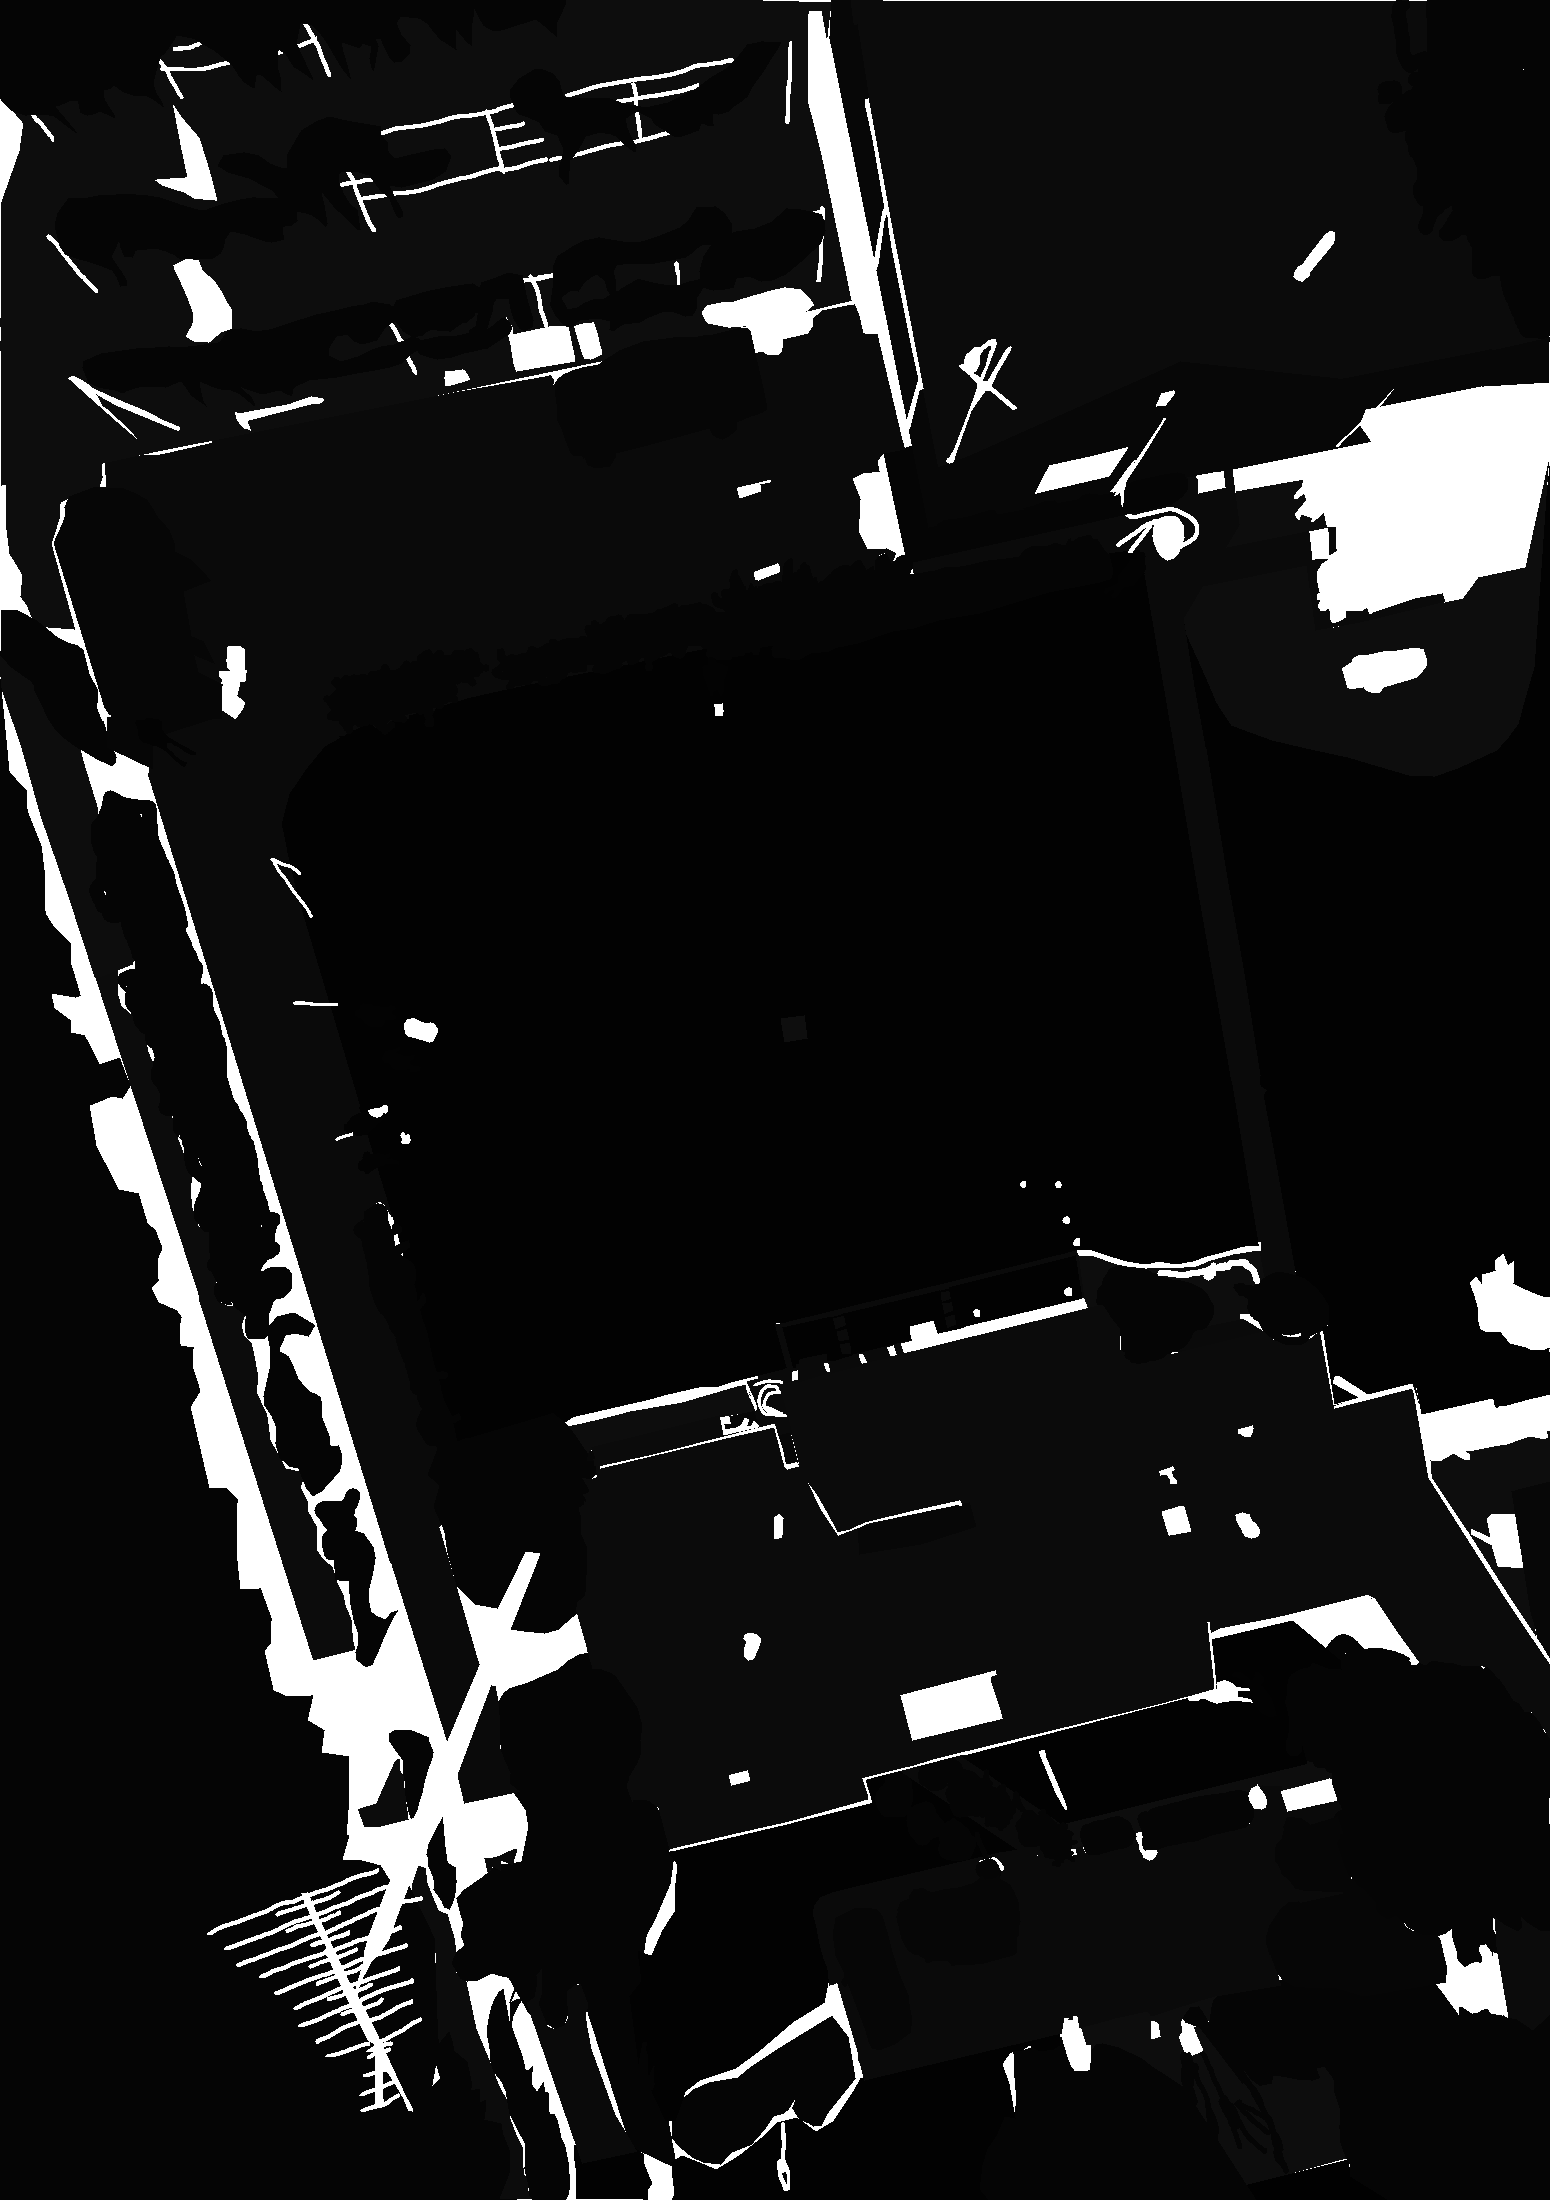

(2200, 1550, 3)
[  1   2   3   5   6   7  10  11  12  13  14 255]


In [ ]:
from google.colab.patches import cv2_imshow
im = cv2.imread("/content/suadd23/semantic_annotations/019c9f9128464ab59a58f2e95f83d55a-1631898858600005621.png")
cv2_imshow(im)
print(im.shape)
print(np.unique(im))

In [ ]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

#Capture training image info as a list
def load_images(a, b):
  train_image_names = glob.glob("/content/suadd23/inputs/*.png")
  train_mask_names = glob.glob("/content/suadd23/semantic_annotations/*.png")

  train_image_names.sort()
  train_mask_names.sort()

  train_images = [cv2.resize(cv2.imread(img, 0), (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST) for img in train_image_names[a:b]]
  train_masks = [cv2.resize(cv2.imread(msk, 0), (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)  for msk in train_mask_names[a:b]]

  print(np.unique(train_masks[0]))

  train_images = np.array(train_images)

  train_masks = np.array(train_masks)

  return train_images, train_masks

In [ ]:
#RUN TILL HERE FOR BATCH TRAINING

In [ ]:
train_images, train_masks = load_images(200, 400)

[  1   2   3   5   6   7   8   9  10  11  12  13  14 255]


In [ ]:
train_masks.shape

(200, 256, 256)

In [ ]:
print(np.unique(train_masks))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 255]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
n, h, w = train_masks.shape
reshaped = train_masks.reshape(-1, 1)
reshaped_encode = le.fit_transform(reshaped)
encoded = reshaped_encode.reshape(n, h, w)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
n_classes = len(np.unique(encoded))
encoded = np.expand_dims(encoded, axis=3)
encoded.shape

(200, 256, 256, 1)

In [ ]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(encoded, num_classes = n_classes)
train_masks_cat = train_masks_cat.reshape(n, h, w, n_classes)

In [ ]:
train_masks_cat.shape

(200, 256, 256, 17)

In [ ]:
from google.colab.patches import cv2_imshow

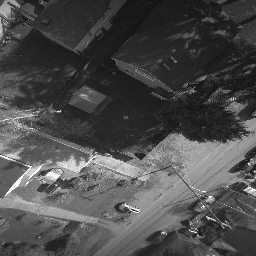

In [ ]:
cv2_imshow(train_images[0])

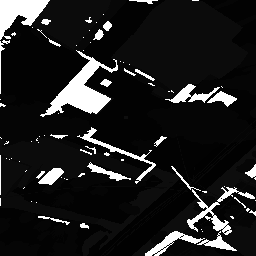

In [ ]:
cv2_imshow(train_masks[0])

In [ ]:
print(train_images[0])
print(train_masks[0])

[[61 61 82 ... 52 51 52]
 [55 99 62 ... 45 48 51]
 [94 66 67 ... 47 48 52]
 ...
 [80 45 58 ... 48 47 46]
 [52 47 70 ... 47 49 50]
 [63 61 64 ... 50 49 35]]
[[255 255 255 ...   2   2   2]
 [255 255 255 ...   2   2   2]
 [255 255 255 ...   2   2   2]
 ...
 [  5   5   5 ...  11  11  11]
 [  5   5   5 ...  11  11  11]
 [  5   5   5 ...  11  11  11]]


In [ ]:
#RUN THIS CODE COMPULSORY EVEN WITH BATCH TRAINING

In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [ ]:
def IoU(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection

    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def fcn(input_shape, num_classes):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Encoding layers
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoding layers
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    # Define the model
    model2 = keras.Model(inputs=inputs, outputs=outputs)

    return model2

input_shape = (256, 256, 1)
num_classes = 17
model2 = fcn(input_shape, num_classes)
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=IoU)

In [ ]:
print(model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_13[0][0]']              
                                )                                                           

In [ ]:
#TILL HERE

In [ ]:
X = train_images[:200]
Y = train_masks_cat[:200]
print(X.shape, Y.shape)

# Y = np.expand_dims(Y, axis=3)


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=12)

(200, 256, 256) (200, 256, 256, 17)


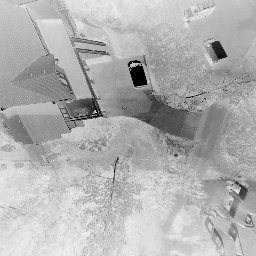

In [ ]:
cv2_imshow(x_val[20]*255)


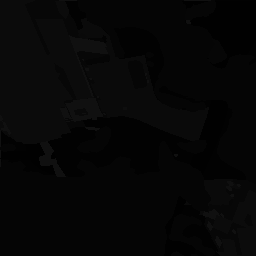

In [ ]:
cv2_imshow(np.argmax(y_val[20], axis=2))

In [ ]:
history = model2.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=25,
   verbose=1,
   validation_data=(x_val, y_val)
)

Epoch 1/25
10/10 [==============================] - 25s 650ms/step - loss: 4.3945 - IoU: 0.0422 - val_loss: 2.5286 - val_IoU: 0.0534
Epoch 2/25
10/10 [==============================] - 3s 321ms/step - loss: 2.4249 - IoU: 0.0642 - val_loss: 2.2501 - val_IoU: 0.0737
Epoch 3/25
10/10 [==============================] - 3s 316ms/step - loss: 2.2945 - IoU: 0.0722 - val_loss: 2.2104 - val_IoU: 0.0784
Epoch 4/25
10/10 [==============================] - 3s 320ms/step - loss: 2.2406 - IoU: 0.0789 - val_loss: 2.1940 - val_IoU: 0.0735
Epoch 5/25
10/10 [==============================] - 3s 314ms/step - loss: 2.2040 - IoU: 0.0791 - val_loss: 2.1526 - val_IoU: 0.0781
Epoch 6/25
10/10 [==============================] - 3s 313ms/step - loss: 2.1286 - IoU: 0.0875 - val_loss: 2.1095 - val_IoU: 0.0817
Epoch 7/25
10/10 [==============================] - 3s 312ms/step - loss: 2.0732 - IoU: 0.0998 - val_loss: 2.2287 - val_IoU: 0.0687
Epoch 8/25
10/10 [==============================] - 3s 319ms/step - loss: 2

In [ ]:
loss, val_loss, acc, val_acc = [], [], [], []

In [ ]:
#RUN THIS CELL AT THE END OF BATCH TRAINING, UNCOMMENT ALL IF NOT BATCH TRAINING

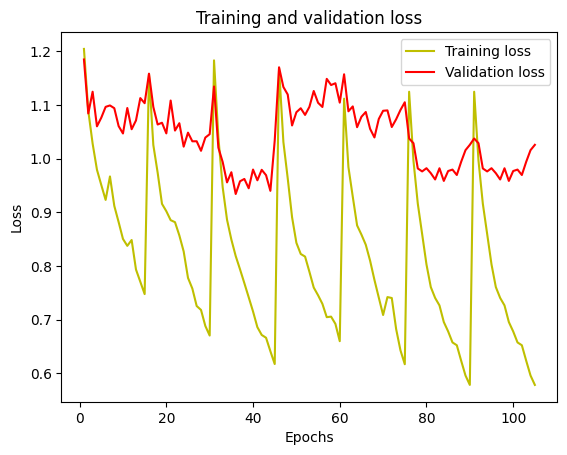

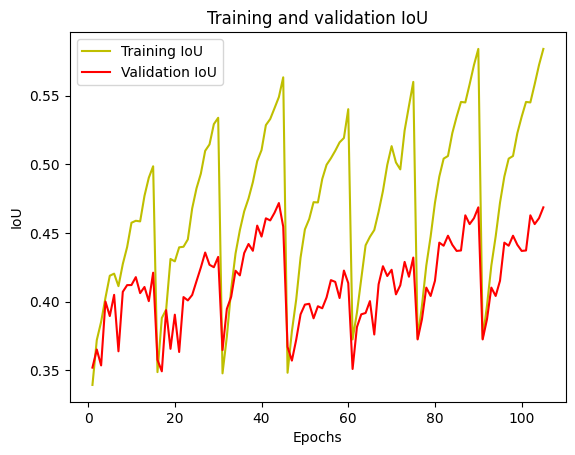

In [ ]:
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc.extend(history.history['IoU'])
val_acc.extend(history.history['val_IoU'])

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
y_pred=model2.predict(x_val)

2/2 [==============================] - 4s 12ms/step


In [ ]:
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

(40, 256, 256, 17)
(40, 256, 256)


31
1/1 [==============================] - 0s 21ms/step


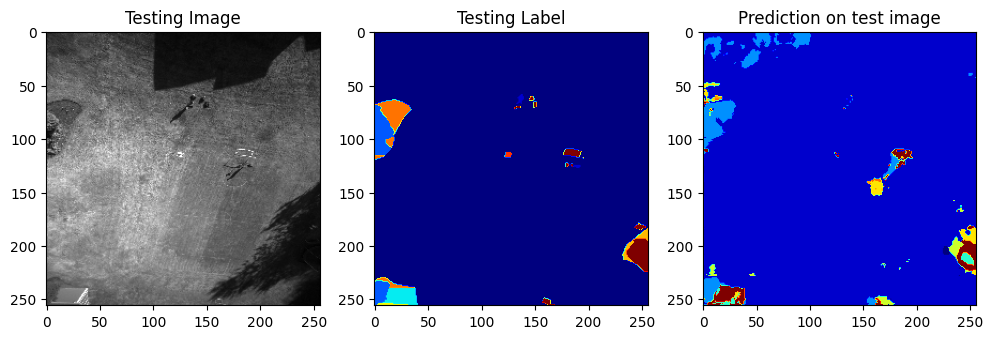

In [ ]:
import random
test_img_number = random.randint(0, len(x_val)-1)
# test_img_number = 9
print(test_img_number)
test_img = x_val[test_img_number]
ground_truth=y_val[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model2.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.argmax(ground_truth, axis = 2), cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
model2.save("FCN.v2")

In [ ]:
model = keras.models.load_model("FCN.v1", custom_objects={ 'IoU':IoU})

In [ ]:
train_images, train_masks = 0, 0

In [ ]:
#AUTO RUN CODE FOR MULTIPLE BATCH TESTING

[  1   2   3   5   6   7  10  11  12  13  14 255]
Loading images for batch 0 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 0 started
Epoch 1/15
10/10 [==============================] - 3s 320ms/step - loss: 1.2047 - IoU: 0.3394 - val_loss: 1.1850 - val_IoU: 0.3520
Epoch 2/15
10/10 [==============================] - 3s 292ms/step - loss: 1.0892 - IoU: 0.3720 - val_loss: 1.0843 - val_IoU: 0.3652
Epoch 3/15
10/10 [==============================] - 3s 289ms/step - loss: 1.0282 - IoU: 0.3853 - val_loss: 1.1248 - val_IoU: 0.3536
Epoch 4/15
10/10 [==============================] - 3s 298ms/step - loss: 0.9794 - IoU: 0.4028 - val_loss: 1.0604 - val_IoU: 0.4001
Epoch 5/15
10/10 [==============================] - 3s 301ms/step - loss: 0.9509 - IoU: 0.4189 - val_loss: 1.0765 - val_IoU: 0.3896
Epoch 6/15
10/10 [==============================] - 3s 289ms/step - loss: 0.9232 - IoU: 0.4204 - val_loss: 1.0966 - val_IoU: 0.4050
Epoch 7/15
10/10 [==============================] - 3s 303ms/step - loss: 0.9669 - IoU: 0.4113 - val_loss: 1.0993 - val_IoU: 0.3639
Epoch 8/15
10/10 [=======================

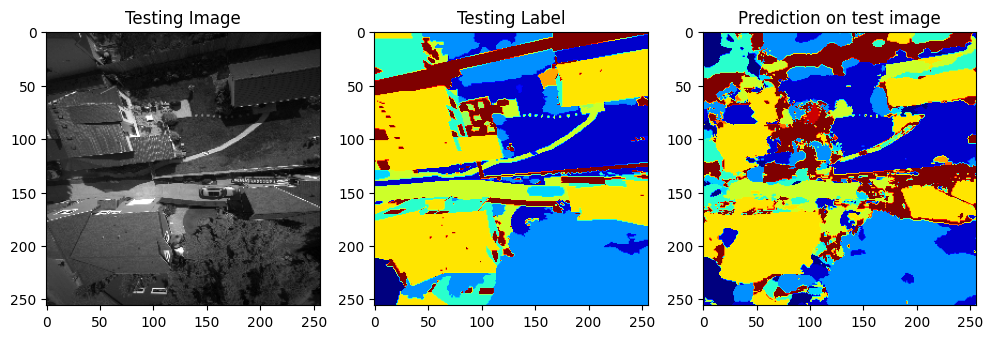

[  1   2   3   5   6   7   8   9  10  11  12  13  14 255]
Loading images for batch 1 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 1 started
Epoch 1/15
10/10 [==============================] - 3s 328ms/step - loss: 1.1579 - IoU: 0.3487 - val_loss: 1.1585 - val_IoU: 0.3576
Epoch 2/15
10/10 [==============================] - 3s 281ms/step - loss: 1.0256 - IoU: 0.3881 - val_loss: 1.0965 - val_IoU: 0.3493
Epoch 3/15
10/10 [==============================] - 3s 284ms/step - loss: 0.9739 - IoU: 0.3943 - val_loss: 1.0638 - val_IoU: 0.3938
Epoch 4/15
10/10 [==============================] - 3s 307ms/step - loss: 0.9158 - IoU: 0.4311 - val_loss: 1.0670 - val_IoU: 0.3657
Epoch 5/15
10/10 [==============================] - 3s 293ms/step - loss: 0.9021 - IoU: 0.4294 - val_loss: 1.0472 - val_IoU: 0.3906
Epoch 6/15
10/10 [==============================] - 3s 294ms/step - loss: 0.8854 - IoU: 0.4396 - val_loss: 1.1084 - val_IoU: 0.3634
Epoch 7/15
10/10 [==============================] - 3s 297ms/step - loss: 0.8817 - IoU: 0.4400 - val_loss: 1.0525 - val_IoU: 0.4034
Epoch 8/15
10/10 [=======================

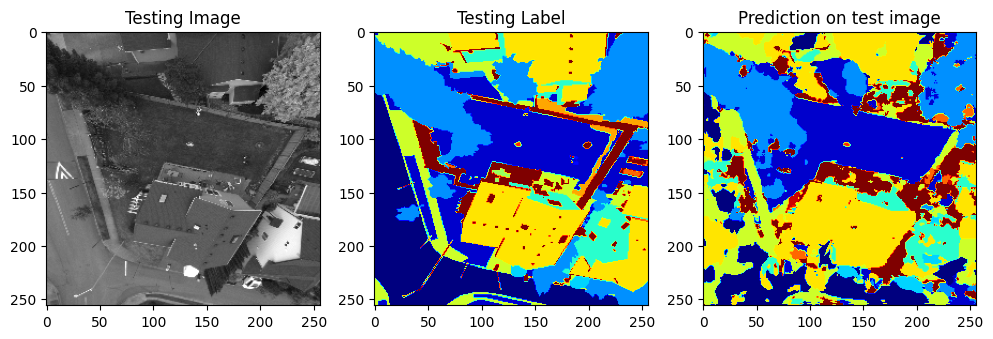

[  2   3   5   6   7  10  11  12  13  14 255]
Loading images for batch 2 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 2 started
Epoch 1/15
10/10 [==============================] - 3s 326ms/step - loss: 1.1833 - IoU: 0.3478 - val_loss: 1.1346 - val_IoU: 0.3648
Epoch 2/15
10/10 [==============================] - 3s 282ms/step - loss: 1.0402 - IoU: 0.3746 - val_loss: 1.0206 - val_IoU: 0.3948
Epoch 3/15
10/10 [==============================] - 3s 282ms/step - loss: 0.9466 - IoU: 0.4092 - val_loss: 0.9938 - val_IoU: 0.4036
Epoch 4/15
10/10 [==============================] - 3s 301ms/step - loss: 0.8863 - IoU: 0.4350 - val_loss: 0.9559 - val_IoU: 0.4225
Epoch 5/15
10/10 [==============================] - 3s 296ms/step - loss: 0.8492 - IoU: 0.4521 - val_loss: 0.9747 - val_IoU: 0.4192
Epoch 6/15
10/10 [==============================] - 3s 292ms/step - loss: 0.8186 - IoU: 0.4658 - val_loss: 0.9342 - val_IoU: 0.4354
Epoch 7/15
10/10 [==============================] - 3s 296ms/step - loss: 0.7937 - IoU: 0.4752 - val_loss: 0.9579 - val_IoU: 0.4420
Epoch 8/15
10/10 [=======================

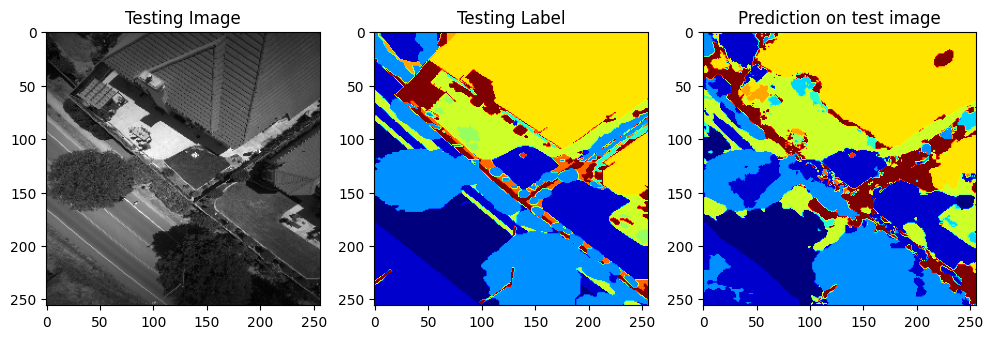

[  1   2   3   5   6   7   9  10  11  14 255]
Loading images for batch 3 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 3 started
Epoch 1/15
10/10 [==============================] - 4s 363ms/step - loss: 1.1687 - IoU: 0.3483 - val_loss: 1.1704 - val_IoU: 0.3671
Epoch 2/15
10/10 [==============================] - 3s 295ms/step - loss: 1.0311 - IoU: 0.3784 - val_loss: 1.1337 - val_IoU: 0.3571
Epoch 3/15
10/10 [==============================] - 3s 297ms/step - loss: 0.9633 - IoU: 0.4017 - val_loss: 1.1197 - val_IoU: 0.3724
Epoch 4/15
10/10 [==============================] - 3s 295ms/step - loss: 0.8910 - IoU: 0.4321 - val_loss: 1.0619 - val_IoU: 0.3908
Epoch 5/15
10/10 [==============================] - 3s 313ms/step - loss: 0.8431 - IoU: 0.4526 - val_loss: 1.0867 - val_IoU: 0.3979
Epoch 6/15
10/10 [==============================] - 3s 297ms/step - loss: 0.8224 - IoU: 0.4603 - val_loss: 1.0941 - val_IoU: 0.3985
Epoch 7/15
10/10 [==============================] - 3s 297ms/step - loss: 0.8175 - IoU: 0.4725 - val_loss: 1.0816 - val_IoU: 0.3879
Epoch 8/15
10/10 [=======================

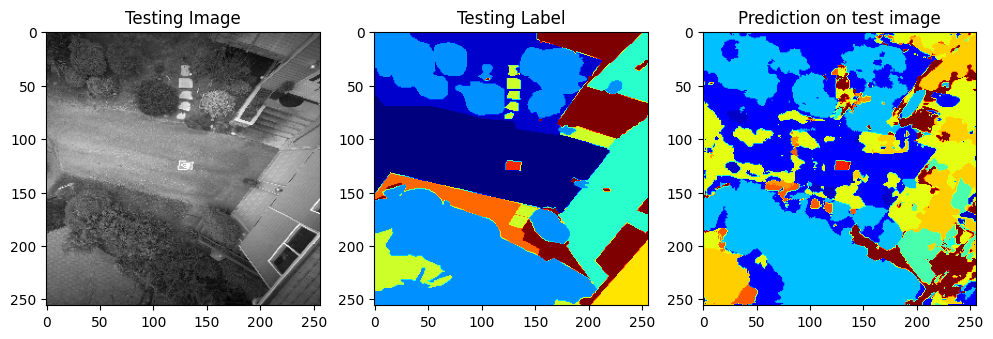

[  2   3   5   7   9  10  11  12  13  14 255]
Loading images for batch 4 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 4 started
Epoch 1/15
10/10 [==============================] - 3s 341ms/step - loss: 1.1119 - IoU: 0.3725 - val_loss: 1.1573 - val_IoU: 0.3510
Epoch 2/15
10/10 [==============================] - 3s 317ms/step - loss: 0.9843 - IoU: 0.3919 - val_loss: 1.0884 - val_IoU: 0.3815
Epoch 3/15
10/10 [==============================] - 3s 310ms/step - loss: 0.9293 - IoU: 0.4167 - val_loss: 1.0975 - val_IoU: 0.3908
Epoch 4/15
10/10 [==============================] - 3s 301ms/step - loss: 0.8756 - IoU: 0.4411 - val_loss: 1.0587 - val_IoU: 0.3918
Epoch 5/15
10/10 [==============================] - 3s 309ms/step - loss: 0.8585 - IoU: 0.4473 - val_loss: 1.0781 - val_IoU: 0.4004
Epoch 6/15
10/10 [==============================] - 3s 328ms/step - loss: 0.8396 - IoU: 0.4522 - val_loss: 1.0871 - val_IoU: 0.3761
Epoch 7/15
10/10 [==============================] - 3s 314ms/step - loss: 0.8098 - IoU: 0.4655 - val_loss: 1.0556 - val_IoU: 0.4127
Epoch 8/15
10/10 [=======================

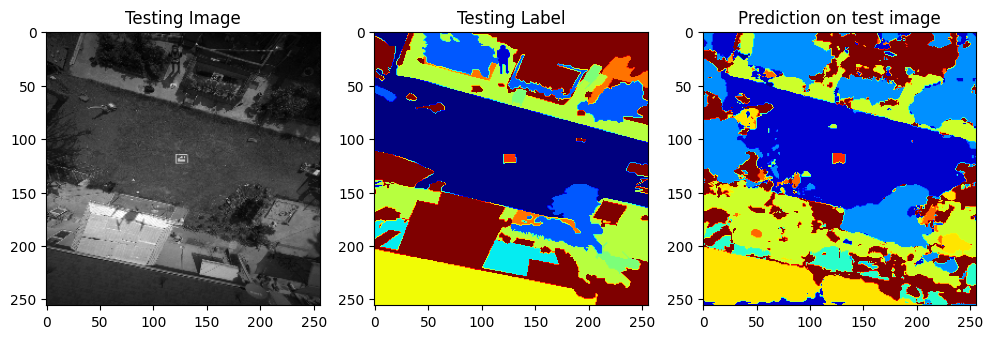

[  2   3   5   7   9  10  11  12  13  14 255]
Loading images for batch 5 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 5 started
Epoch 1/15
10/10 [==============================] - 3s 335ms/step - loss: 1.1248 - IoU: 0.3731 - val_loss: 1.0376 - val_IoU: 0.3725
Epoch 2/15
10/10 [==============================] - 3s 311ms/step - loss: 0.9963 - IoU: 0.3972 - val_loss: 1.0288 - val_IoU: 0.3872
Epoch 3/15
10/10 [==============================] - 3s 307ms/step - loss: 0.9161 - IoU: 0.4263 - val_loss: 0.9818 - val_IoU: 0.4103
Epoch 4/15
10/10 [==============================] - 3s 306ms/step - loss: 0.8596 - IoU: 0.4475 - val_loss: 0.9763 - val_IoU: 0.4042
Epoch 5/15
10/10 [==============================] - 3s 299ms/step - loss: 0.8030 - IoU: 0.4721 - val_loss: 0.9822 - val_IoU: 0.4152
Epoch 6/15
10/10 [==============================] - 3s 319ms/step - loss: 0.7606 - IoU: 0.4911 - val_loss: 0.9730 - val_IoU: 0.4430
Epoch 7/15
10/10 [==============================] - 3s 298ms/step - loss: 0.7404 - IoU: 0.5042 - val_loss: 0.9613 - val_IoU: 0.4408
Epoch 8/15
10/10 [=======================

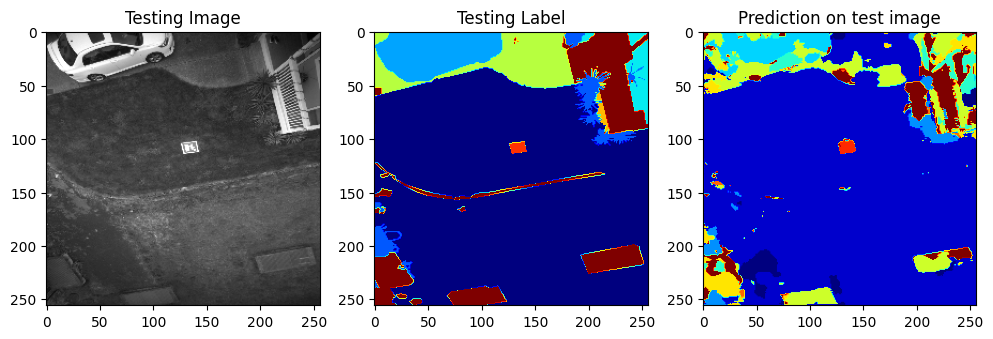

In [ ]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
loss, val_loss, acc, val_acc = [], [], [], []
SIZE_Y = 256
batch_start = 0
batch_end = 1200
batch_size = 200
for batch in range(batch_start, batch_end, batch_size):
  train_images,  train_masks =  load_images(batch, batch+batch_size)
  print(f"Loading images for batch {(batch-batch_start)//batch_size} completed")

  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  n, h, w = train_masks.shape
  reshaped = train_masks.reshape(-1, 1)
  reshaped_encode = le.fit_transform(reshaped)
  encoded = reshaped_encode.reshape(n, h, w)

  n_classes = len(np.unique(encoded))
  encoded = np.expand_dims(encoded, axis=3)

  from keras.utils import to_categorical
  train_masks_cat = to_categorical(encoded, num_classes = n_classes)
  train_masks_cat = train_masks_cat.reshape(n, h, w, n_classes)

  X = train_images[:200]
  Y = train_masks_cat[:200]

  from sklearn.model_selection import train_test_split
  x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=12)

  print(f"Training model for batch {(batch-batch_start)//batch_size} started")
  history = model2.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=15,
   verbose=1,
   validation_data=(x_val, y_val)
  )

  print(f"Training model for batch {(batch-batch_start)//batch_size} completed")

  acc.extend(history.history['IoU'])
  val_acc.extend(history.history['val_IoU'])
  loss.extend(history.history['loss'])
  val_loss.extend(history.history['val_loss'])

  import random
  # test_img_number = random.randint(0, len(x_val)-1)
  test_img_number = 18
  print(f"Test image number: {test_img_number}, Batch number: {(batch-batch_start)//batch_size}")
  test_img = x_val[test_img_number]
  ground_truth=y_val[test_img_number]
  # test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model2.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img, cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(np.argmax(ground_truth, axis = 2), cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()